In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
plt.style.use('seaborn-white')

In [19]:
# grab the advertising and credit datasets and use specified columns
# Advertising Data
advertising_data = pd.read_csv('Data/Advertising.csv',usecols=[1,2,3,4])

# Credit Data
credit_data = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
# remap values of student column to binary
credit_data['Student2'] = credit_data.Student.map({'No':0, 'Yes':1})

# Auto data
auto_data = pd.read_csv('Data/Auto.csv', na_values='?').dropna()

In [20]:
advertising_data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [21]:
credit_data.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,0
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0


In [22]:
auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


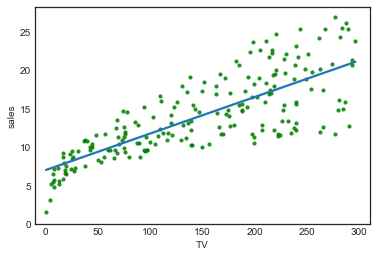

In [23]:
# fit a line to the data
sns.regplot(advertising_data.TV,
            advertising_data.sales,
            order=1,
            ci=None,
            scatter_kws={'color':'g', 's':10}
            )
# set axis lmits
plt.xlim(-10,310)
plt.ylim(ymin=0);

In [24]:
# Grab the regression coefficients using ordinary least squares
regr = skl_lm.LinearRegression()

X = scale(advertising_data.TV,
          with_mean=True,
          with_std=False
          ).reshape(-1,1)
y = advertising_data.sales

# Add in our data
regr.fit(X,y)
print("Intercept:", regr.intercept_)
print("Coefficient:", regr.coef_[0])

Intercept: 14.0225
Coefficient: 0.04753664043301975


In [25]:
# Create grid coordinates for plotting
# use linspace to get 50 evenly spaced intervales between intercept and coefficent
Beta0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
Beta1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
# use 
xx, yy = np.meshgrid(Beta0, Beta1, indexing='xy')
Z = np.zeros((Beta0.size,Beta1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

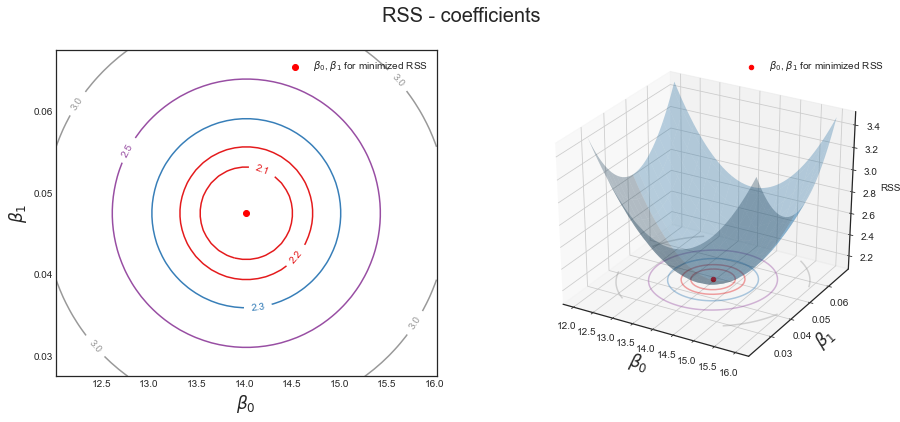

In [26]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - coefficients', fontsize=20)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# use the same params across plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

In [27]:
# grab confidence intervals
est = smf.ols('sales ~ TV', advertising_data).fit()
print(est.summary().tables[1],"\n",)

# RSS with regression coefficients
rss_rc = ((advertising_data.sales - (est.params[0] + est.params[1]*advertising_data.TV))**2).sum()/1000
print("RSS with regression coefficients:",rss_rc)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053

RSS with regression coefficients: 2.102530583131351


In [28]:
# now running with multiple regression
# sales and radio
est = smf.ols('sales ~ radio', advertising_data).fit()
print(est.summary().tables[1], "\n")
# now the same for newspaper
est = smf.ols('sales ~ newspaper', advertising_data).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3116      0.563     16.542      0.000       8.202      10.422
radio          0.2025      0.020      9.921      0.000       0.162       0.243

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3514      0.621     19.876      0.000      11.126      13.577
newspaper      0.0547      0.017      3.300      0.001       0.022       0.087


In [37]:
est = smf.ols('sales ~ TV + radio + newspaper', advertising_data).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 14 May 2020   Prob (F-statistic):           1.58e-96
Time:                        12:05:55   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# create a correlation matrix
advertising_data.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


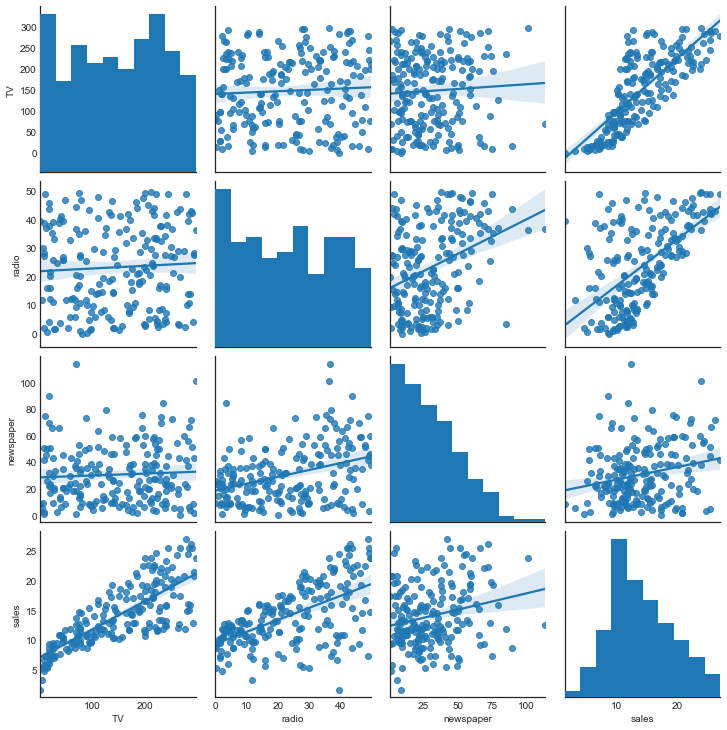

In [39]:
# take a loot a potential correlations using a pairplot, fit a regression line to them
sns.pairplot(advertising_data[['TV','radio','newspaper','sales']], kind="reg");


In [31]:
# Run using radio and TV with sklearn
regr = skl_lm.LinearRegression()

X = advertising_data[['radio', 'TV']].to_numpy()
y = advertising_data.sales

regr.fit(X,y)
print("Coefficients:",regr.coef_)
print("Intercept:", regr.intercept_)


Coefficients: [0.18799423 0.04575482]
Intercept: 2.9210999124051398


In [32]:
# Create a coordinate grid
radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(radio, TV, indexing='xy')
Z = np.zeros((TV.size, radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])# Create a coordinate grid
radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(radio, TV, indexing='xy')
Z = np.zeros((TV.size, radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

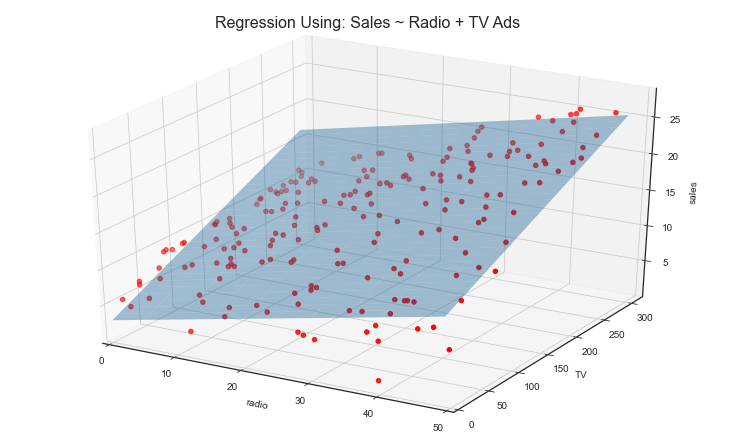

In [33]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression Using: Sales ~ Radio + TV Ads', fontsize=16)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising_data.radio, advertising_data.TV, advertising_data.sales, c='r')

ax.set_xlabel('radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('sales');